<center><h1>Qi_Hui_HW5</h1></center>
<br>
<br>

Name: Hui Qi
<br>
Github Username: yufeifeiqiqi
<br>
USC ID: 3206742781

## 1. Decision Trees as Interpretable Models

Import packages

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn import datasets
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import  GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import model_selection

import xgboost as xgb

### (a) Obtain Data

Get the Accute Inamations Data Set

In [111]:
column_name = ['a1','a2','a3','a4','a5','a6','d1','d2']
df = pd.read_csv('../data/diagnosis.data', header = None, names = column_name, sep = '\t',encoding = 'utf-16')
df

,a1,a2,a3,a4,a5,a6,d1,d2
0,"35,5",no,yes,no,no,no,no,no
1,"35,9",no,no,yes,yes,yes,yes,no
2,"35,9",no,yes,no,no,no,no,no
3,"36,0",no,no,yes,yes,yes,yes,no
4,"36,0",no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,"41,4",no,yes,yes,no,yes,no,yes
116,"41,5",no,no,no,no,no,no,no
117,"41,5",yes,yes,no,yes,no,no,yes
118,"41,5",no,yes,yes,no,yes,no,yes


In [123]:
# replace , in a1 with . 
# replace yes, no with 1, 0

df = df.replace(regex={',': '.', 'yes':1, 'no': 0 })
df['a1']=df['a1'].astype(float)
df

,a1,a2,a3,a4,a5,a6,d1,d2
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


### (b) Build a decision tree

In [135]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# https://www.graphviz.org
# https://scikit-learn.org/stable/modules/tree.html

# get the features and labels
feature_cols = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6']
labels = ['d1','d2']
X = df[feature_cols]
y = df[labels]


# 30% test, 70% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100) 
# Build decision tree classifier
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt_result =dt.fit(X_train, y_train)
y_pred = dt_result.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [136]:
# Can also import graphviz  to graph , see https://scikit-learn.org/stable/modules/tree.html
dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names=feature_cols)
dotfile.close()

#### Copying the contents of the created file ('dt.dot' in our example) to a graphviz rendering agent, we get the following representation of our decision tree:

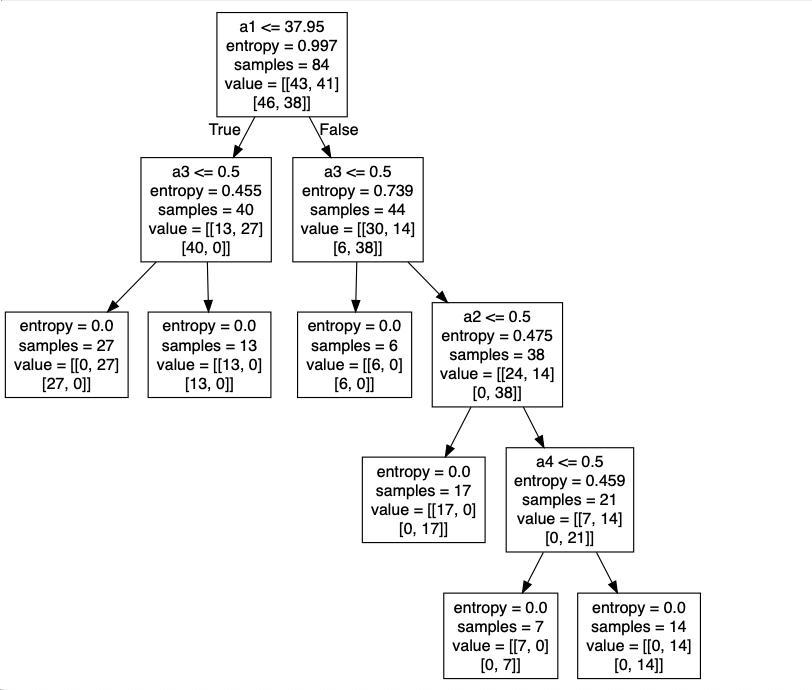

### (c) Convert the decision rules

In [151]:
# https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
# Convert the decision rules into a set of IF-THEN rules.
def tree_to_pseudo(tree, feature_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

tree_to_pseudo(dt, list(X))

 if ( a1 <= 37.95000076293945 ) {
   if ( a3 <= 0.5 ) {
     return [[ 0. 27.]
 [27.  0.]]
   } else {
     return [[13.  0.]
 [13.  0.]]
   }
 } else {
   if ( a3 <= 0.5 ) {
     return [[6. 0.]
 [6. 0.]]
   } else {
     if ( a2 <= 0.5 ) {
       return [[17.  0.]
 [ 0. 17.]]
     } else {
       if ( a4 <= 0.5 ) {
         return [[7. 0.]
 [0. 7.]]
       } else {
         return [[ 0. 14.]
 [ 0. 14.]]
       }
     }
   }
 }


### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [184]:
# https://www.kaggle.com/code/arunmohan003/pruning-decision-trees-tutorial
# https://vzhang1999.medium.com/classification-tree-growing-and-pruning-with-python-code-grid-search-cost-complexity-function-b2e45e33a1a4

# Pre pruning: grid search those parameters and choose the optimum values that gives better performace on test data.
'''
max_depth: maximum depth of decision tree
min_sample_split: The minimum number of samples required to split an internal node:
min_samples_leaf: The minimum number of samples required to be at a leaf node.
'''
# Start with an initial guess for parameters
param_grid = {
 'max_depth':[5,10,20],
 'min_samples_split':[20,40,60,80],
 'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.005, 0.01]
}
gridSearch = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=1)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.8683823529411765
Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}


In [187]:
# Adapt grid based on result from initial grid search
param_grid = {
 'max_depth': list(range(3,12)), 
 'min_samples_split': list(range(15, 35)), 
 'min_impurity_decrease': [x/10000 for x in range(1, 900, 5)], 
}
gridSearch = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_

Improved score:  1.0
Improved parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.0001, 'min_samples_split': 15}


[Text(0.4, 0.9, 'a1 <= 37.95\ngini = 0.498\nsamples = 84\nvalue = [[43, 41]\n[46, 38]]'),
 Text(0.2, 0.7, 'a3 <= 0.5\ngini = 0.219\nsamples = 40\nvalue = [[13, 27]\n[40, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 27\nvalue = [[0, 27]\n[27, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 13\nvalue = [[13, 0]\n[13, 0]]'),
 Text(0.6, 0.7, 'a3 <= 0.5\ngini = 0.335\nsamples = 44\nvalue = [[30, 14]\n[6, 38]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 6\nvalue = [[6, 0]\n[6, 0]]'),
 Text(0.7, 0.5, 'a5 <= 0.5\ngini = 0.233\nsamples = 38\nvalue = [[24, 14]\n[0, 38]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 17\nvalue = [[17, 0]\n[0, 17]]'),
 Text(0.8, 0.3, 'a4 <= 0.5\ngini = 0.222\nsamples = 21\nvalue = [[7, 14]\n[0, 21]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 7\nvalue = [[7, 0]\n[0, 7]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 14\nvalue = [[0, 14]\n[0, 14]]')]

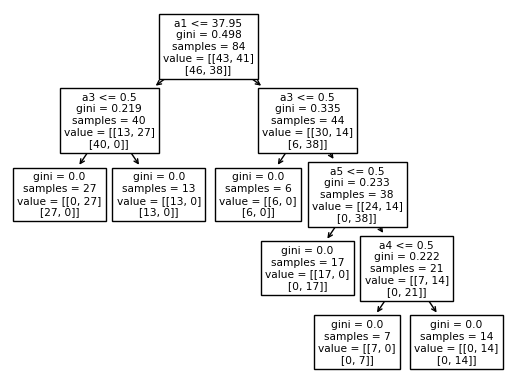

In [190]:
# fit the final model with best parameters: {'max_depth': 4, 'min_impurity_decrease': 0.0001, 'min_samples_split': 15

prunedtree = tree.DecisionTreeClassifier(random_state = 1, max_depth=4, min_impurity_decrease=0.0001, min_samples_split=15)
prunedtree.fit(X_train, y_train)
tree.plot_tree(prunedtree, feature_names=feature_cols)

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [3]:
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

df_1 = pd.read_csv('../data/communities.data', header = None, na_values='?')
trainset = df_1[0:1495]
testset = df_1[1495:]
trainset

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,6,NaN,NaN,Hillsboroughtown,8,0.00,0.59,0.01,0.69,1.00,...,0.02,0.14,0.22,NaN,NaN,NaN,NaN,0.00,NaN,0.03
1491,6,NaN,NaN,Orangecity,8,0.16,0.62,0.03,0.74,0.48,...,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1492,13,NaN,NaN,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,...,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.00,NaN,0.30
1493,39,85.0,49056.0,Mentorcity,8,0.06,0.53,0.01,0.98,0.05,...,0.08,0.15,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


### (b) Missing values

In [4]:
trainset.head(10)
# the first 5 columns are non-predictive. they are ['state', 'county', 'community', 'communityname', 'fold']
df_1 = df_1.iloc[:,5:]
df_1

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [5]:
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

# with SimpleImputer, we use the default mean of each column to replace missing values
'''
>>> imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
>>> imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
SimpleImputer()
>>> X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
>>> print(imp_mean.transform(X))
'''
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Fit to data, then transform it.
df_1 = imp_mean.fit_transform(df_1)
df_1 = pd.DataFrame(df_1)
#df_1

trainset = df_1[:1495]
testset = df_1[1495:]


X_train = trainset.iloc[:,:-1]
y_train = trainset.iloc[:,-1]

X_test = testset.iloc[:,:-1]
y_test = testset.iloc[:,-1]


X_test

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
1495,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.305987,0.01,0.23,0.73,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
1496,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.305987,0.01,0.18,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
1497,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.305987,0.01,0.18,0.00,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
1498,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.305987,0.06,0.13,0.16,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
1499,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.305987,0.03,0.23,0.06,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.305987,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.305987,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.250000,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.190000,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000


### (c) Plot a correlation matrix

In [6]:
corr_matrix = df_1.corr()
corr_matrix

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
0,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.713652,0.231897,0.270356,0.609147,0.595543,-0.061583,0.076527,0.466352,-0.035576,0.367157
1,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,-0.015078,-0.004072,-0.051506,-0.032663,-0.007584,-0.006426,-0.000280,-0.094368,-0.054562,-0.034923
2,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,0.149758,0.095053,0.147023,0.122017,0.083179,-0.082660,0.010987,0.260793,0.022237,0.631264
3,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.131389,-0.337458,-0.215636,-0.109191,-0.114860,0.052940,-0.033209,-0.276234,-0.006323,-0.684770
4,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,-0.001084,0.389944,0.296921,-0.017992,0.067745,0.032389,0.065424,0.101888,-0.011619,0.037622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,-0.061583,-0.006426,-0.082660,0.052940,0.032389,0.024366,0.000652,0.013327,0.013687,0.005601,...,-0.067678,0.055734,0.023457,-0.115349,-0.089736,1.000000,0.007179,0.021153,-0.237240,-0.039002
119,0.076527,-0.000280,0.010987,-0.033209,0.065424,0.025956,0.011271,0.005145,-0.001001,-0.042756,...,0.109830,-0.076634,-0.082946,0.078436,0.023349,0.007179,1.000000,-0.015712,-0.021100,0.055038
120,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,0.299632,0.228084,0.206644,-0.052426,-0.062677,0.021153,-0.015712,1.000000,0.018649,0.348627
121,-0.035576,-0.054562,0.022237,-0.006323,-0.011619,0.002234,-0.076589,-0.068575,-0.049876,0.076586,...,-0.113166,0.067199,0.080024,0.245532,0.259342,-0.237240,-0.021100,0.018649,1.000000,0.045466


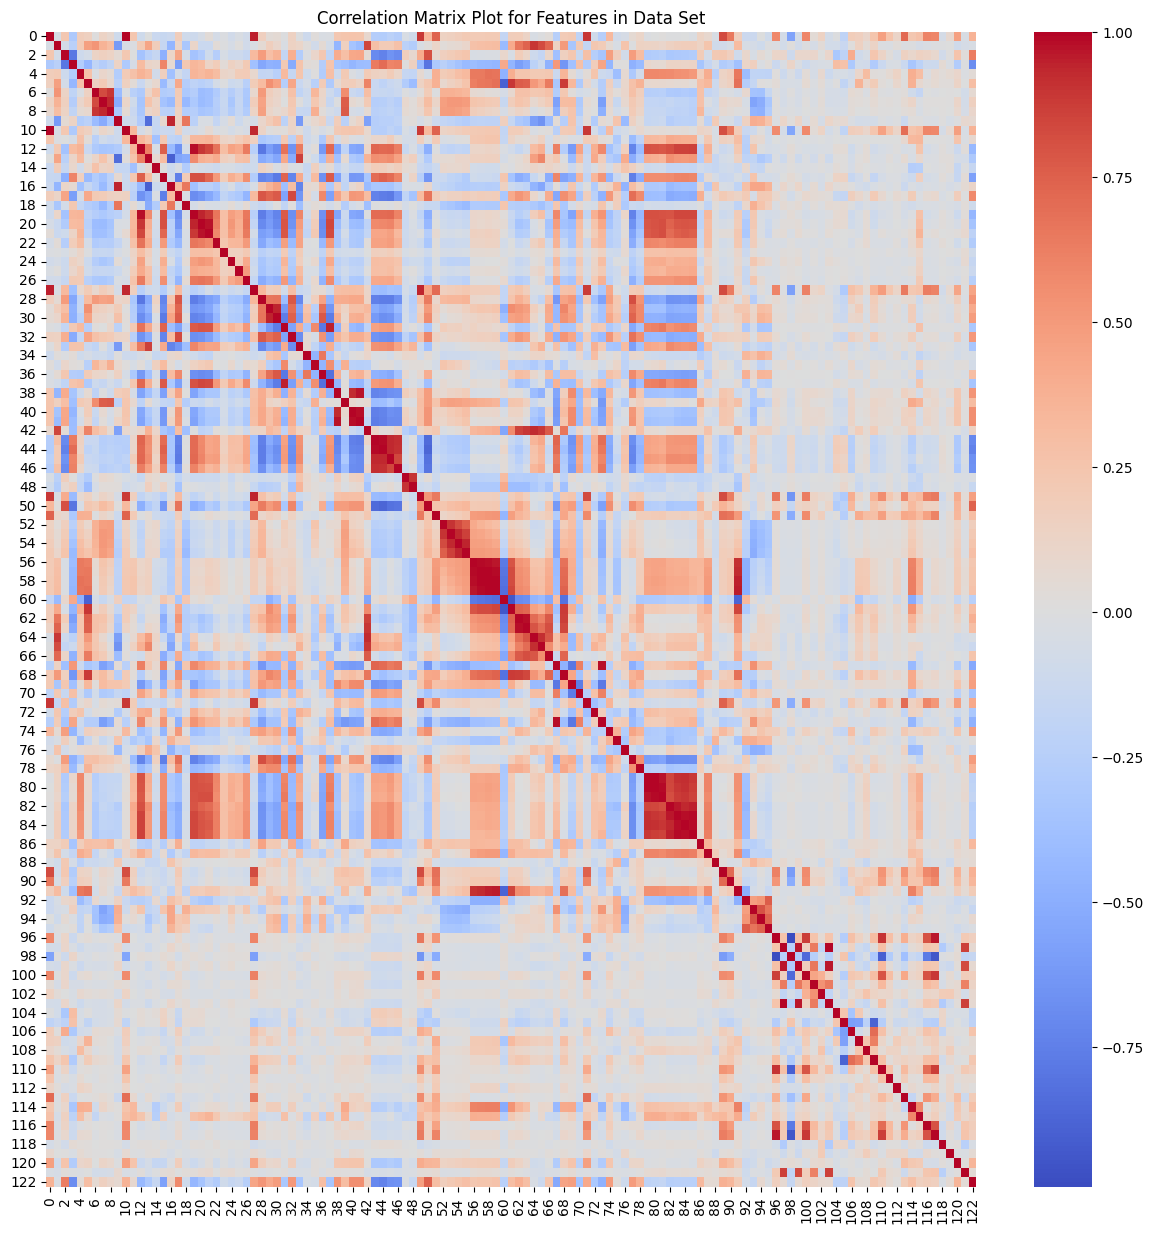

In [15]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plt.subplots(figsize=(120, 120))
'''
sn.heatmap(corr_matrix, annot=True)
plt.show()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
'''
plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlation Matrix Plot for Features in Data Set")
plt.show()
#ax.set(xlabel="", ylabel="")

### (d) Calculate the Coefficient of Variation CV

In [18]:
# https://stackoverflow.com/questions/42754627/coefficient-of-variation-and-numpy
# https://numpy.org/doc/stable/reference/generated/numpy.apply_along_axis.html
# https://stackoverflow.com/questions/9019581/what-does-numpy-apply-along-axis-perform-exactly

cv =  lambda x: np.std(x) / np.mean(x)
var = np.apply_along_axis(cv, axis = 1, arr = np.array(X_train).T)
varation = pd.DataFrame(var, columns=["varation"])
varation

,varation
0,2.240355
1,0.355681
2,1.428407
3,0.330102
4,1.358645
...,...
117,0.774085
118,0.117949
119,0.370877
120,2.552092


### (e) Scatter plots and box plots for highest CV features

#### It is very hard to draw conclusions about significance of these features just by the scatter plots below.

feature number is 11


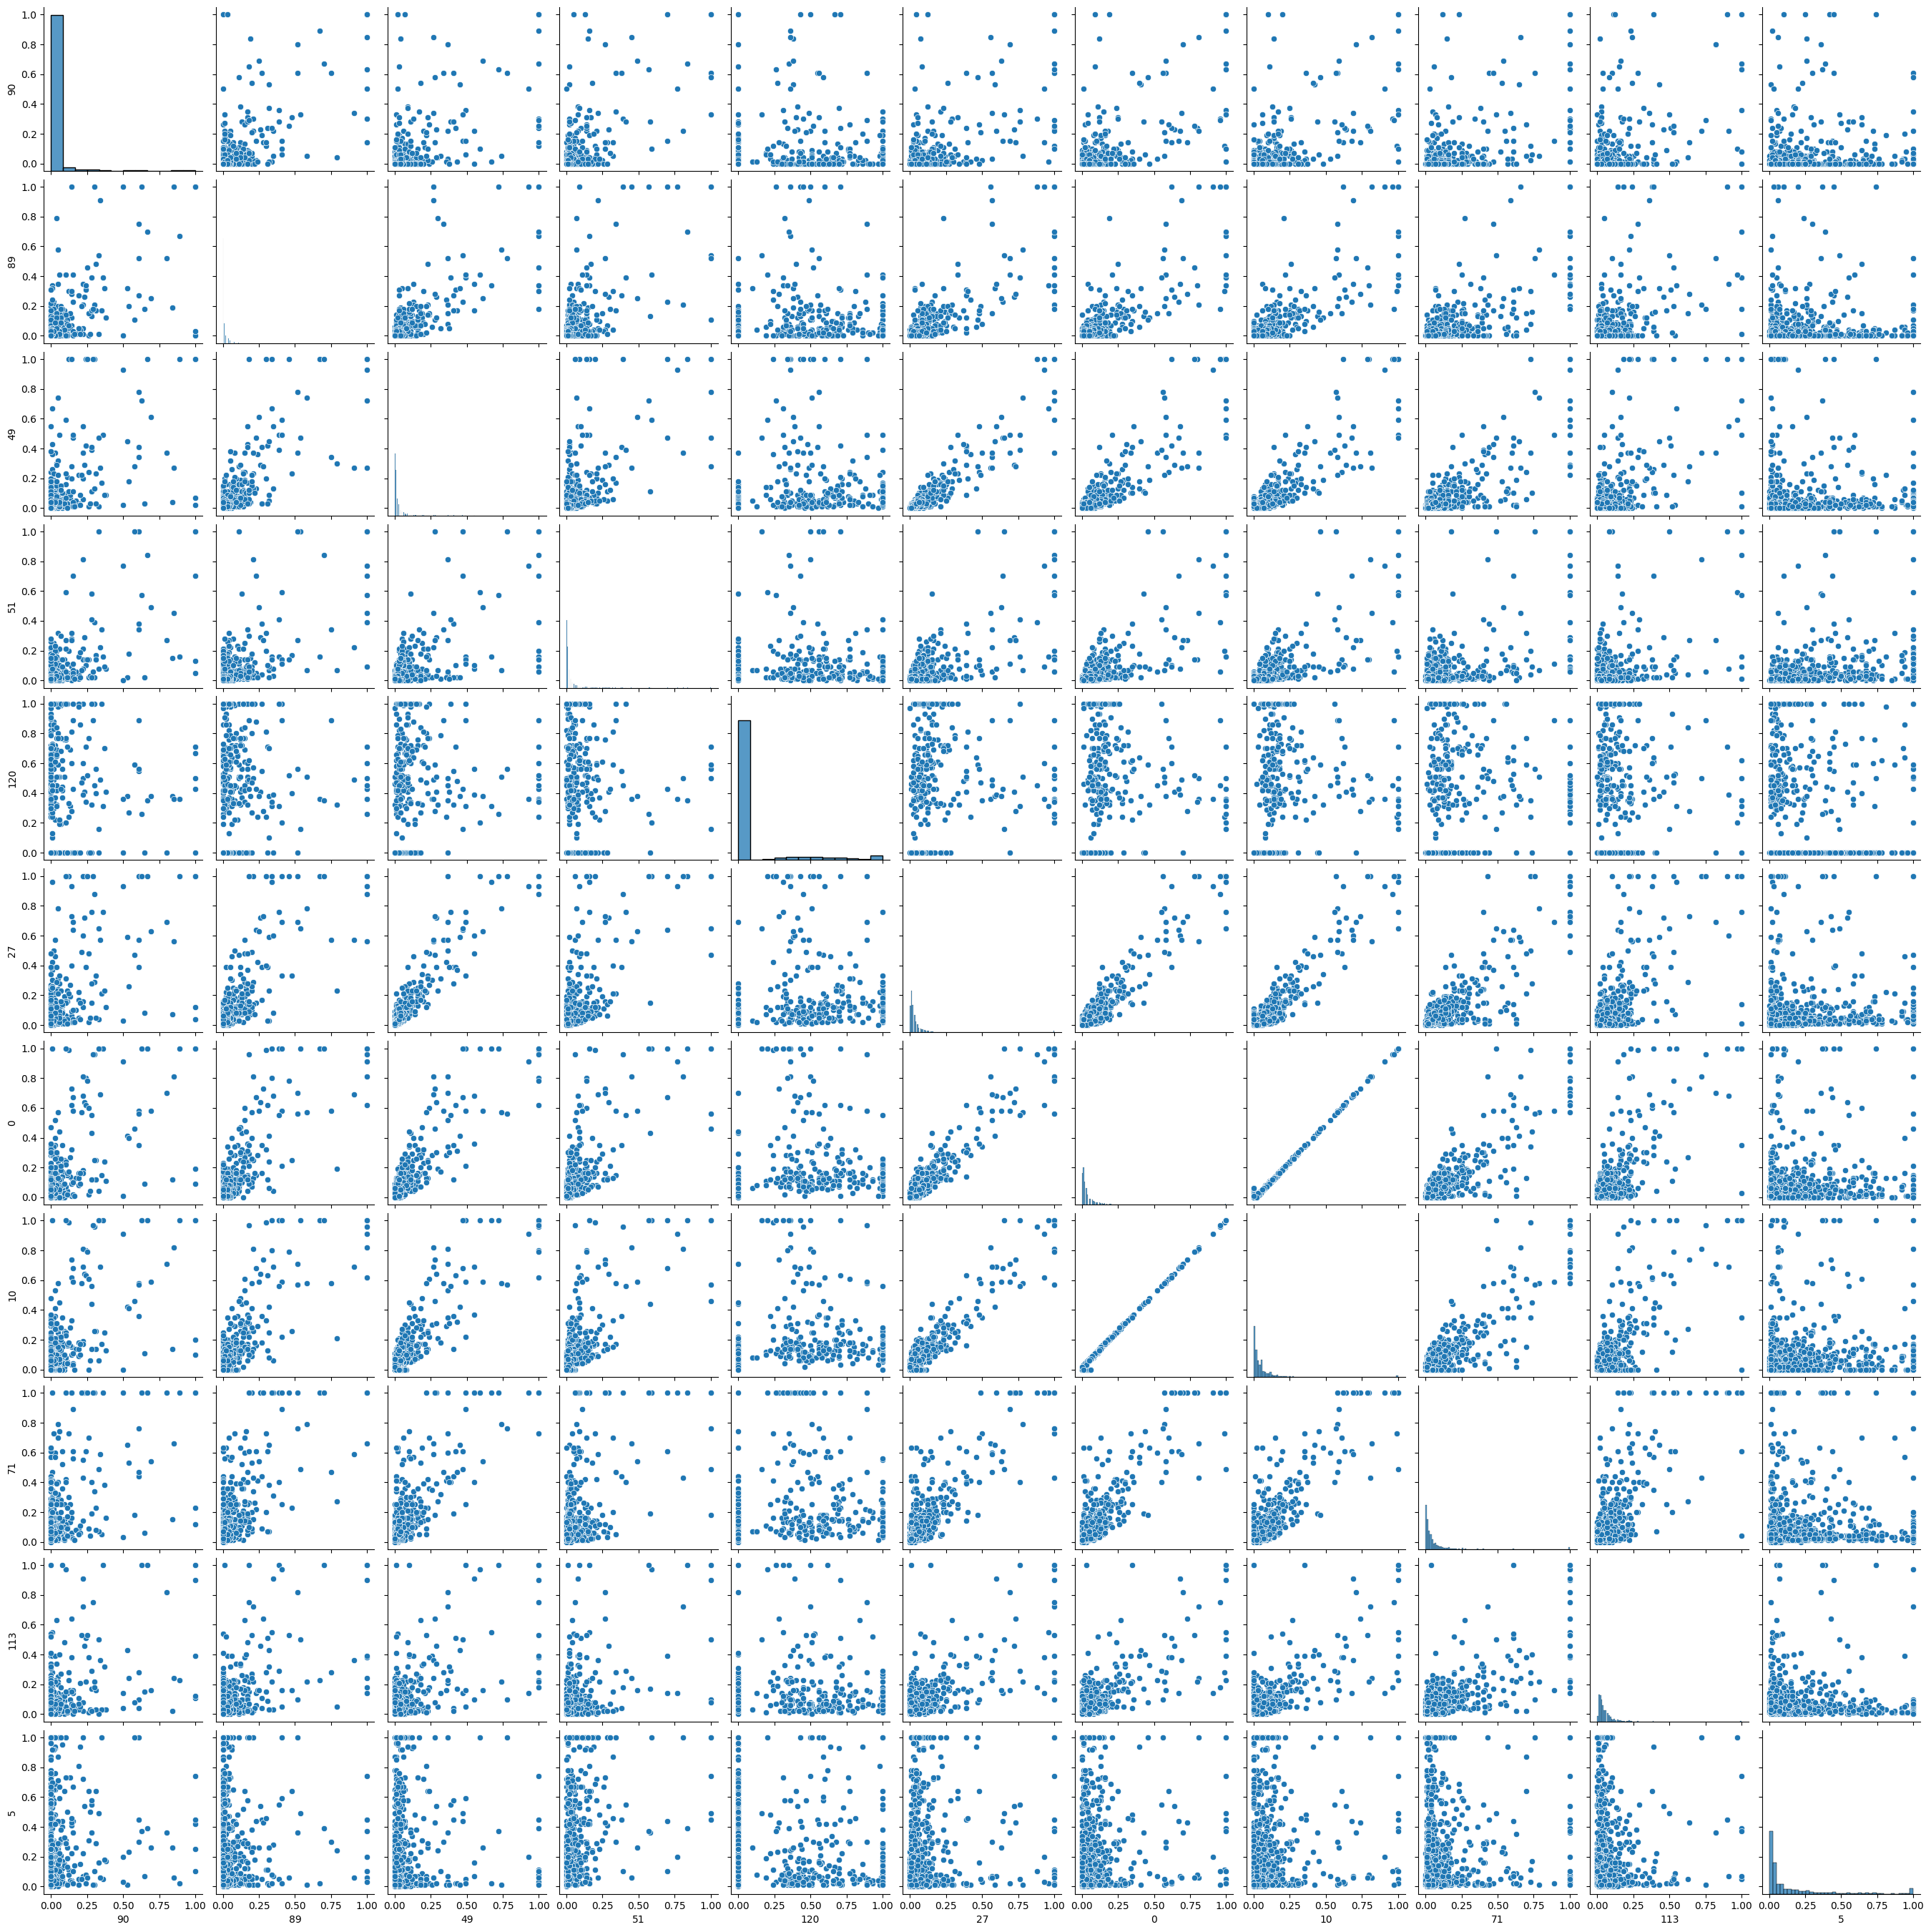

In [29]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
# https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/
threshold = math.floor(pow(128,0.5))
print('feature number is', threshold)
sorted_var = varation.sort_values('varation', ascending=False)

# get first 11 features from threshold
features = sorted_var[:threshold].T
features
train_features = trainset.iloc[:, features.columns]
#train_features

# The plot_kws and diag_kws parameters 
# accept dicts of keyword arguments to customize the off-diagonal and diagonal plots, respectively
sns.pairplot(train_features)
plt.show()

### (f) Fit a linear model

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

reg = LinearRegression().fit(X_train, y_train)
y_predict = reg.predict(X_test)

mse = mean_squared_error(y_test, y_predict)
print("MSE:", mse)

MSE: 0.7897255274315268


### (g) Fit a ridge regression model

In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
alphas=[1e-3, 1e-2, 1e-1, 1]
# 5 folds
clf = RidgeCV(alphas=alphas, cv = 5).fit(X_train, y_train)
y_predict = clf.predict(X_test)

r2 = clf.score(X_test, y_test)
mse = mean_squared_error(y_test, y_predict)

print('Best λ: ', clf.alpha_)
print('R-Square:', r2)
print('MSE:', mse)

Best λ:  1.0
R-Square: 0.627021995706937
MSE: 0.017737081104303682


### (h) Fit a LASSO model

In [51]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

# Lasso selects a list of the variables, but we have not standardized them in this case
alphas=[1e-3, 1e-2, 1e-1, 1]
lasso_model = LassoCV(alphas = alphas, cv=5, random_state=0).fit(X_train, y_train)
y_predict = lasso_model.predict(X_test)

r2 = lasso_model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_predict)
print('Best λ: ', lasso_model.alpha_)
print('R-Square:', r2)
print('MSE:', mse)


Best λ:  0.001
R-Square: 0.6310550538601054
MSE: 0.017545287811568618


In [55]:
# standardized selected features

# first only select features that their coefficient is not 0, sparsity
selected_features = (lasso_model.coef_ != 0)
#print(selected_features)
X_train.iloc[:, selected_features]

,2,3,7,11,17,24,38,44,45,48,...,71,72,74,86,88,90,91,94,119,120
0,0.02,0.90,0.47,1.0,0.15,0.27,0.68,0.59,0.61,0.76,...,0.21,0.71,0.05,0.38,0.25,0.00,0.12,0.51,0.500000,0.32
1,0.12,0.74,0.59,1.0,0.29,0.30,1.00,0.47,0.60,0.53,...,0.02,0.79,0.02,0.29,0.18,0.00,0.21,0.60,0.440439,0.00
2,0.49,0.56,0.47,0.0,0.40,0.29,0.63,0.44,0.43,0.67,...,0.01,0.86,0.29,0.48,0.28,0.00,0.14,0.67,0.440439,0.00
3,1.00,0.08,0.50,1.0,0.20,0.25,0.34,0.54,0.83,0.86,...,0.01,0.97,0.60,0.63,0.47,0.00,0.19,0.64,0.440439,0.00
4,0.02,0.95,0.38,0.9,0.11,0.74,0.22,0.91,0.89,0.60,...,0.01,0.89,0.04,0.22,0.21,0.00,0.11,0.61,0.440439,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.01,0.69,0.28,1.0,0.09,1.00,0.08,0.96,1.00,0.00,...,0.01,0.85,0.09,0.00,0.19,0.00,0.61,0.72,0.440439,0.00
1491,0.03,0.74,0.57,1.0,0.26,0.41,0.45,0.62,0.77,0.54,...,0.06,0.90,0.10,0.62,0.15,0.03,0.60,0.68,0.500000,0.61
1492,0.95,0.24,0.42,0.0,0.94,0.29,0.71,0.18,0.00,0.46,...,0.05,0.45,0.19,0.65,0.56,0.00,0.02,0.77,0.440439,0.00
1493,0.01,0.98,0.40,1.0,0.13,0.42,0.31,0.86,0.91,0.57,...,0.02,0.93,0.14,0.38,0.31,0.00,0.08,0.70,0.440439,0.00


#### After standardized features

In [61]:
# standardized selected features
# https://scikit-learn.org/stable/modules/preprocessing.html
scaler = preprocessing.StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.fit_transform(X_test)

alphas=[1e-3, 1e-2, 1e-1, 1]
lasso_model = LassoCV(alphas = alphas, cv=5, random_state=0).fit(X_train_stand, y_train)
y_predict = lasso_model.predict(X_test_stand)

r2 = lasso_model.score(X_test_stand, y_test)
mse = mean_squared_error(y_test, y_predict)
print('Best λ: ', lasso_model.alpha_)
print('R-Square:', r2)
print('MSE:', mse)

Best λ:  0.001
R-Square: 0.622438475885954
MSE: 0.017955051767110063


#### MSE is 0.01754 before standardizing features while MSE is 0.01796 after standardizing features. MSE is lower before standardizing features, but the difference between these two MSE is very small. Therefore, standardizing features does not significantly improve the Lasso model to overcome overfitting in this question.

### (i) Fit a PCR model

In [90]:
# https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
# https://www.statology.org/principal-components-regression-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
# http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
# 122 features

M = range(1,123)
best_m = 1
best_mse = 1
mse_list = []
for m in M:
    pca = PCA(n_components=m)
    X_reduced = pca.fit_transform(X_train)
    linear_model = LinearRegression()
    scores = model_selection.cross_validate(linear_model, X_reduced, \
                            y_train, cv=3, scoring=('r2', 'neg_mean_squared_error'))
    mse = (-1*scores['test_neg_mean_squared_error']).mean()
    r2 = scores['test_r2'].mean()
    #print(m, mse)
    if mse < best_mse:
        best_mse = mse
        best_m = m
print('Best M:', best_m)
print('Best MSE:', best_mse)

Best M: 86
Best MSE: 0.019673015417581742


### (j) Fit a boosting tree

In [106]:
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html
# https://stackoverflow.com/questions/34469038/understanding-python-xgboost-cv
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://stackoverflow.com/questions/68766331/how-to-apply-predict-to-xgboost-cross-validation

#To load a NumPy array into DMatrix
dtrain = xgb.DMatrix(data = X_train, label=y_train)

a_list = [1e-3, 1e-2, 1e-1, 1]
a_list = np.power(10, a_list)

for a in a_list:
    # Booster Parameters : alpha for L1
    params = {'max_depth':2, 'eta':0.3, 'alpha':a}
    scores = xgb.cv(params, dtrain, num_boost_round=100, early_stopping_rounds=50, nfold=5, metrics='rmse')
    mse = scores['test-rmse-mean'].mean()
    print('α:', a)
    print('MSE:', mse)


α: 1.0023052380778996
MSE: 0.1460887781416411
α: 1.023292992280754
MSE: 0.14952088125504687
α: 1.2589254117941673
MSE: 0.1464041744913726
α: 10.0
MSE: 0.16839613917100715


#### From the results above, MSE is smallest at α = 1.0023052380778996, which is 0.1460887781416411.

## Reference

https://xgboost.readthedocs.io/en/stable/python/python_intro.html<br>
https://stackoverflow.com/questions/34469038/understanding-python-xgboost-cv<br>
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/<br>
https://stackoverflow.com/questions/68766331/how-to-apply-predict-to-xgboost-cross-validation<br>
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA<br>
https://www.statology.org/principal-components-regression-in-python/<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html<br>
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html<br>
https://scikit-learn.org/stable/modules/preprocessing.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html<br>
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html<br>
https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/<br>
https://stackoverflow.com/questions/42754627/coefficient-of-variation-and-numpy<br>
https://numpy.org/doc/stable/reference/generated/numpy.apply_along_axis.html<br>
https://stackoverflow.com/questions/9019581/what-does-numpy-apply-along-axis-perform-exactly<br>
https://seaborn.pydata.org/generated/seaborn.heatmap.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html<br>
https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html<br>
https://www.graphviz.org<br>
https://scikit-learn.org/stable/modules/tree.html<br>
https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html<br>
https://www.kaggle.com/code/arunmohan003/pruning-decision-trees-tutorial<br>
https://vzhang1999.medium.com/classification-tree-growing-and-pruning-with-python-code-grid-search-cost-complexity-function-b2e45e33a1a4<br>